<a href="https://colab.research.google.com/github/marketakvasova/LSEC_segmentation/blob/main/automatic_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automatic segmentation of electron microscope images**

This notebook is intended for training a neural network for the task of binary segmentation of fenestrations of Liver sinusoidal entdothelial cells (LSECS).

# How to use this notebook

To train a network, first connect to a GPU (**Runtime -> Change runtime time -> Hardware accelerator -> GPU**).

If you are using a pretrained network for inference and not training, being connected only to a **CPU** is slower, but possible.

This notebook works with data saved on your Google Drive. Network training requires pairs of images and their corresponding masks saved in two diferent folders. The image-mask pairs don't need to be named exactly the same, but they should correspond when sorted alphabetically.

In [1]:
# @title  { display-mode: "form" }
#@markdown ##**Run this cell to connect to Google Drive**
#@markdown A new window will open where you will be able to connect.

#@markdown When you are connected, you can see your Drive content in the left sidebar under **Files**.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **1. Setup**

In [2]:
!python --version
!pip install wandb
!pip install torchmetrics
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp
from torchmetrics.classification import Dice, BinaryJaccardIndex
import os
from google.colab import drive
import torch.cuda
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torchsummary import summary
import shutil
import cv2 as cv
from numpy.lib.stride_tricks import as_strided
import pywt
from scipy.stats import norm
from google.colab.patches import cv2_imshow
import gc
import wandb
from numba import njit
from scipy.signal import convolve2d
import math

# gc.collect()
drive.mount('/content/gdrive')
model_folder = "./gdrive/MyDrive/ROI_patches/my_model"
os.makedirs(model_folder, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # TODO: do not even try this, if the gpu is not connected
print(DEVICE)
biomodel_folder = os.path.join(model_folder, "bioimageio_model")
biomodel_path = os.path.join(biomodel_folder, "weights.pt")
os.makedirs(biomodel_folder, exist_ok=True)
LOAD_TRAINED_MODEL = False
model_path = os.path.join(model_folder,"my_checkpoint.pth")

Python 3.10.12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manyli

# Utils

## Data utils

In [3]:
class MyDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transofrm=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transofrm
        self.images = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.masks = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index]) # mask and image need to be called the same
        image = cv.imread(img_path, cv.IMREAD_GRAYSCALE).astype(np.float32)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE).astype(np.float32)
        # mask[mask == 255.0] = 1
        mask /= 255
        return image, mask

class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        augmentations = self.transform(image=image, mask=mask)
        image = augmentations["image"]
        mask = augmentations["mask"]
        return image, mask

    def __len__(self):
        return len(self.dataset)


def get_loaders(img_dir, mask_dir, split, batch_size, num_workers=4, pin_memory=True): # TODO: check these parameters
    data = MyDataset(
        image_dir=img_dir,
        mask_dir=mask_dir,
        transofrm=None
    )

    train_transform, val_transform = get_transforms()

    train_indices, test_indices = train_test_split(
        range(len(data)),
        test_size=split,
        random_state=1
    )
    train_data = TransformDataset(Subset(data, train_indices), train_transform)
    val_data = TransformDataset(Subset(data, test_indices), val_transform)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader, train_indices

def get_transforms():
    train_transform = A.Compose( # TODO: background(preprocessing?), intensity
        [
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.Affine(shear=(0.5,1)),
            # A.Affine(scale=(-10, 10)),
            A.Normalize(
                mean = 0.0,
                std = 1.0,
                max_pixel_value=255.0, # normalization to [0, 1]
            ),
            ToTensorV2()
        ]
    )

    val_transform = A.Compose(
        [
            A.Normalize(
                mean = 0.0,
                std = 1.0,
                max_pixel_value=255.0,
            ),
            ToTensorV2()
        ]
    )
    return train_transform, val_transform

# test_transform = A.Compose(
#     [
#     A.Normalize(
#       mean = 0.0,
#       std = 1.0,
#       max_pixel_value=255.0,
#     ),
#         ToTensorV2()
#     ]
# )

test_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transformations if needed
])


def merge_images(image, mask):
    merge = np.zeros((mask.shape[0], mask.shape[1], 3))
    merge[:, :, 0] = image # B channel (0, 1, 2) = (B, G, R)
    merge[:, :, 2] = image # R channel
    merge[:, :, 1] = mask # G channel
    merge[:, :, 2][mask == 255.0] = 255 # R channel
    merge = merge.astype('uint8')
    return merge


def merge_original_mask(image_path, mask_path, output_folder):
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    merge = merge_images(image, mask)
    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_original_mask_merge"+ext), merge)


def merge_masks(mask1_path, mask2_path, output_folder):
    print('merging masks')
    mask1 = cv.imread(mask1_path, cv.IMREAD_GRAYSCALE)
    mask2 = cv.imread(mask2_path, cv.IMREAD_GRAYSCALE)
    # merge = merge_images(image, mask)
    merge = np.zeros((mask1.shape[0], mask1.shape[1], 3))

    merge[:, :, 1][mask1 == 255.0] = 255
    merge[:, :, 2][mask2 == 255.0] = 255

    filename_ext = os.path.basename(mask1_path)
    filename, ext = os.path.splitext(filename_ext)
    cv.imwrite(os.path.join(output_folder, filename+"_mask_compare"+ext), merge)


def create_weighting_patches(patch_size, edge_size):
    patch = np.ones((patch_size, patch_size), dtype=float)

    # Calculate the linear decrease values
    decrease_values = np.linspace(1, 0, num=edge_size)
    decrease_values = np.tile(decrease_values, (patch_size, 1))
    increase_values = np.linspace(0, 1, num=edge_size)
    increase_values = np.tile(increase_values, (patch_size, 1))

    # Middle patch
    # Apply linear decrease to all four edges
    middle = patch.copy()
    middle[:, 0:edge_size] *= increase_values
    middle[:, patch_size-edge_size:patch_size] *= decrease_values
    middle[0:edge_size, :] *= increase_values.T
    middle[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((middle*255).astype(np.uint8))

    # Left
    left = patch.copy()
    left[:, patch_size-edge_size:patch_size] *= decrease_values
    left[0:edge_size, :] *= increase_values.T
    left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((left*255).astype(np.uint8))

    # Right
    right = patch.copy()
    right[:, 0:edge_size] *= increase_values
    right[0:edge_size, :] *= increase_values.T
    right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((right*255).astype(np.uint8))

    # Top
    top = patch.copy()
    top[:, 0:edge_size] *= increase_values
    top[:, patch_size-edge_size:patch_size] *= decrease_values
    top[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top*255).astype(np.uint8))

    # Bottom
    bottom = patch.copy()
    bottom[:, 0:edge_size] *= increase_values
    bottom[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom*255).astype(np.uint8))

    # Left Top edge
    top_left = patch.copy()
    top_left[:, patch_size-edge_size:patch_size] *= decrease_values
    top_left[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_left*255).astype(np.uint8))

    # Right top edge
    top_right = patch.copy()
    top_right[:, 0:edge_size] *= increase_values
    top_right[patch_size-edge_size:patch_size, :] *= decrease_values.T
    # cv2_imshow((top_right*255).astype(np.uint8))

    # Left bottom edge
    bottom_left = patch.copy()
    bottom_left[:, patch_size-edge_size:patch_size] *= decrease_values
    bottom_left[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_left*255).astype(np.uint8))

    # Right Bottom edge
    bottom_right = patch.copy()
    bottom_right[:, 0:edge_size] *= increase_values
    bottom_right[0:edge_size, :] *= increase_values.T
    # cv2_imshow((bottom_right*255).astype(np.uint8))

    return middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left


def add_mirrored_border(image, border_size, window_size):
    height, width = image.shape

    bottom_edge = window_size - ((height + border_size) % (window_size - border_size))
    right_edge = window_size - ((width + border_size) % (window_size - border_size))

    top_border = np.flipud(image[0:border_size, :])
    bottom_border = np.flipud(image[height - border_size:height, :])
    bottom_zeros = np.zeros((bottom_edge-border_size, width), dtype = image.dtype)
    top_bottom_mirrored = np.vstack((top_border, image, bottom_border, bottom_zeros))

    left_border = np.fliplr(top_bottom_mirrored[:, 0:border_size])
    right_border = np.fliplr(top_bottom_mirrored[:, width - border_size:width])
    right_zeros = np.zeros((top_bottom_mirrored.shape[0], right_edge-border_size), dtype = image.dtype)
    mirrored_image = np.hstack((left_border, top_bottom_mirrored, right_border, right_zeros))
    return mirrored_image

def inference_on_image_with_overlap(model, image_path, filter_type):
    window_size = 512
    oh, ow = 50, 50
    # out_crop =
    input_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image_height, image_width = input_image.shape
    original_height, original_width = image_height, image_width

    # bottom_edge = (image_height + oh) % (window_size - oh)
    # right_edge = (image_height + ow) % (window_size - ow)

    mirrored_image = add_mirrored_border(input_image, oh, window_size)
    # print(mirrored_image.shape)
    image_height, image_width = mirrored_image.shape


    weights = np.zeros((image_height, image_width))
    # tryout = np.zeros((image_height, image_width))
    output_probs = np.zeros((image_height, image_width))
    output_mask = np.zeros((image_height, image_width))
    middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left = create_weighting_patches(window_size, oh)

    for x in range(0, image_height-window_size+1, window_size - oh):
        for y in range(0, image_width-window_size+1, window_size - ow):
            # Choose weighting window
            # print(x, y)
            if x == 0:
                if y == 0:
                    # if original_height != window_size:
                    weighting_window = top_left
                    # print('top left')
                elif y == image_width - window_size:
                    # print('top right')
                    weighting_window = top_right
                else:
                    weighting_window = top
                    # print('top ')
            elif x == image_height - window_size:
                if y == 0:
                    weighting_window = bottom_left
                    # print('bottom left')
                elif y == image_width - window_size:
                    weighting_window = bottom_right
                    # print('bottom right')
                else:
                    weighting_window = bottom
                    # print('bottom')
            elif y == 0:
                weighting_window = left
                # print('left')
            elif y == image_width - window_size:
                weighting_window = right
                # print('right')
            else:
                weighting_window = middle
                # print('middle')
            square_section = mirrored_image[x:x + window_size, y:y + window_size]
            weights[x:x + window_size, y:y + window_size] += weighting_window
            # tryout[x:x + window_size, y:y + window_size] += np.ones((window_size, window_size))*weighting_window
            if filter_type == 'nlm':
                square_section = nlm_filt(square_section)
            elif filter_type == 'med5':
                square_section = cv.medianBlur(square_section, 5) # TODO: prehodit tohle, at se to dela jednou pro celej obrazek, ne pro patche?
            square_tensor = test_transform(square_section).unsqueeze(0).to(DEVICE)  # Add batch dimension

            # Forward pass through the model
            with torch.no_grad():
                output = torch.sigmoid(model(square_tensor)).float()

            # Scale the probablity to 0-255
            output = output*255
            # output = output.to(torch.uint8)
            output_pil = output.squeeze(0).cpu().numpy().squeeze()
            # cv2_imshow(output_pil)
            output_probs[x:x+window_size, y:y+window_size] += output_pil*weighting_window
    # Crop
    # cv.imwrite(os.path.join(output_folder, "probs"+".png"), output_probs)

    output_probs = output_probs[oh:original_height+oh, ow:original_width+ow]
    weights *= 255
    # weights = weights[:original_height, :original_width]*255
    # tryout = tryout[:original_height, :original_width]*255

    # Apply weights
    # output_probs /= weights

    # Create image from mask
    output_mask = np.where(output_probs > 127, 255, 0)
    output_mask = output_mask.astype(np.uint8)
    return output_mask

    # filename_ext = os.path.basename(image_path)
    # filename, ext = os.path.splitext(filename_ext)
    # # cv.imwrite(os.path.join(output_folder, filename+"_mirrored"+ext), mirrored_image)

    # # Merge image with created mask
    # out_mask_path = os.path.join(output_folder, filename+"_new_mask"+ext)
    # merge = merge_images(input_image, output_mask)
    # cv.imwrite(os.path.join(output_folder, filename+"_new_mask_merge"+ext), merge)

    # # cv.imwrite(os.path.join(output_folder, filename+"_probs"+ext), output_probs)
    # cv.imwrite(out_mask_path, output_mask)
    # # cv.imwrite(os.path.join(output_folder, filename+"_weights"+ext), weights)
    # return out_mask_path

# def inference_on_image_with_overlap(model, image_path, output_folder):
#     window_size = 512
#     oh, ow = 124, 124
#     input_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
#     image_height, image_width = input_image.shape
#     original_height, original_width = image_height, image_width
#     bottom_edge = image_height % (window_size - oh)
#     right_edge = image_width % (window_size - ow)
#     mirrored_image = np.zeros((image_height+bottom_edge, image_width+right_edge)).astype(np.uint8)
#     mirrored_image[:image_height, :image_width] = input_image
#     mirrored_image[image_height:, :image_width] = np.flipud(input_image[image_height-bottom_edge:, :])
#     mirrored_image[:, image_width:] = np.fliplr(mirrored_image[:, image_width-right_edge:image_width])
#     image_height += bottom_edge
#     image_width += right_edge
#     weights = np.zeros((image_height, image_width))
#     # tryout = np.zeros((image_height, image_width))
#     output_probs = np.zeros((image_height, image_width))
#     output_mask = np.zeros((image_height, image_width))
#     middle, top_left, top, top_right, right, bottom_right, bottom, bottom_left, left = create_weighting_patches(window_size, oh)

#     for x in range(0, image_height-window_size+1, window_size - oh):
#         for y in range(0, image_width-window_size+1, window_size - ow):
#             # Choose weighting window
#             if x == 0:
#                 if y == 0:
#                     if original_height != window_size:
#                         weighting_window = top_left
#                     else:
#                         weighting_window = np.ones((window_size, window_size))
#                 elif y == window_size - ow - 1:
#                     weighting_window = top_right
#                 else:
#                     weighting_window = top
#             elif x == window_size - oh - 1:
#                 if y == 0:
#                     weighting_window = bottom_left
#                 elif y == window_size - ow - 1:
#                     weighting_window = bottom_right
#                 else:
#                     weighting_window = bottom
#             elif y == 0:
#                 weighting_window = left
#             elif y == window_size - ow - 1:
#                 weighting_window = right
#             else:
#                 weighting_window = middle
#             square_section = mirrored_image[x:x + window_size, y:y + window_size]
#             weights[x:x + window_size, y:y + window_size] = weighting_window
#             # tryout[x:x + window_size, y:y + window_size] += np.ones((window_size, window_size))*weighting_window
#             square_section = preprocess_image(square_section)
#             square_tensor = test_transform(square_section).unsqueeze(0).to(DEVICE)  # Add batch dimension

#             # Forward pass through the model
#             with torch.no_grad():
#                 output = torch.sigmoid(model(square_tensor)).float()

#             # Scale the probablity to 0-255
#             output = output*255
#             output = output.to(torch.uint8)
#             output_pil = output.squeeze(0).cpu().numpy()
#             output_probs[x:x+window_size, y:y+window_size] += output_pil.squeeze()*weighting_window
#     # Crop
#     output_probs = output_probs[:original_height, :original_width]
#     # weights = weights[:original_height, :original_width]*255
#     # tryout = tryout[:original_height, :original_width]*255

#     # Apply weights
#     # output_probs /= weights

#     # Create image from mask
#     output_mask = np.where(output_probs > 127, 255, 0)
#     output_mask = output_mask.astype(np.uint8)
#     filename_ext = os.path.basename(image_path)
#     filename, ext = os.path.splitext(filename_ext)

#     # Merge image with created mask
#     out_mask_path = os.path.join(output_folder, filename+"_mask"+ext)
#     merge = merge_images(input_image, output_mask)
#     cv.imwrite(os.path.join(output_folder, filename+"_merge"+ext), merge)

#     cv.imwrite(os.path.join(output_folder, filename+"_probs"+ext), output_probs)
#     cv.imwrite(out_mask_path, output_mask)
#     # cv.imwrite(os.path.join(output_folder, filename+"_weights"+ext), weights)
#     return out_mask_path


def preprocess_image(image):
    # image = nlm_filt(image)
    # image = wavelet_denoise(image, threshold=1.5)
    # image = apply_clahe(image)
    # image = cv.medianBlur(image, 5)
    return image


def apply_clahe(image):
    clahe = cv.createCLAHE(clipLimit=0.8, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    return clahe_image


def create_image_patches(image_folder, mask_folder, output_folder, patch_size):
    image_patches_path = os.path.join(output_folder,'image_patches')
    mask_patches_path = os.path.join(output_folder,'mask_patches')
    # rejected_path = os.path.join(output_folder,'rejected')
    # print(image_path)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    if os.path.exists(image_patches_path):
        shutil.rmtree(image_patches_path)
    os.mkdir(image_patches_path)
    if os.path.exists(mask_patches_path):
        shutil.rmtree(mask_patches_path)
    os.mkdir(mask_patches_path)
    # if os.path.exists(rejected_path):
    #     shutil.rmtree(rejected_path)
    # os.mkdir(rejected_path)

    patch_area = patch_size**2
    fenestration_area_thresh = 0.0 #0.01
    image_filenames = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    image_filenames = sorted(image_filenames)
    mask_filenames = [f for f in os.listdir(mask_folder) if os.path.isfile(os.path.join(mask_folder, f))]
    mask_filenames = sorted(mask_filenames)

    for image_name, mask_name in zip(image_filenames, mask_filenames):
        # if image_name.endswith(".tif"): # TODO: tohle mozna odstranit
        input_path = os.path.join(image_folder, image_name)
        mask_path = os.path.join(mask_folder, mask_name)

        img = cv.imread(input_path, cv.IMREAD_GRAYSCALE)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        height, width = img.shape

        shape = (height // patch_size, width // patch_size, patch_size, patch_size)
        strides = (patch_size * width , patch_size , width, 1)
        # strides = (patch_size * width , patch_size)

        # img_strided = as_strided(img, shape=(width//patch_size, height//patch_size, patch_size, patch_size),
        #              strides=img.strides + img.strides, writeable=False)
        img_strided = as_strided(img, shape=shape,
                        strides=strides, writeable=False) #TODO: check if the patches do not overlap
        mask_strided = as_strided(mask, shape=shape,
                        strides=strides, writeable=False)

        for i in range(img_strided.shape[0]):
            for j in range(img_strided.shape[1]):
                img_patch = img_strided[i, j]
                mask_patch = mask_strided[i, j]
                # Compute the percentage of white pixels
                fenestration_area = np.sum(mask_patch == 255)
                # print(fenestration_area)
                # fenestration_percentage = fenestration_area/patch_area
                if fenestration_area >= fenestration_area_thresh:
                    patch_filename = f"{os.path.splitext(os.path.basename(image_name))[0]}_patch_{i}_{j}.tif"
                    # preprocess image
                    img_patch = preprocess_image(img_patch)
                    cv.imwrite(os.path.join(image_patches_path, patch_filename), img_patch)
                    cv.imwrite(os.path.join(mask_patches_path, patch_filename), mask_patch)
                    # print("written patch ", patch_filename)
                else:
                    print("not writing patch")
    return image_patches_path, mask_patches_path


# Denoising
#   References for non-local means filtering and noise variance estimation:
#
#   [1] Antoni Buades, Bartomeu Coll, and Jean-Michel Morel, A Non-Local
#       Algorithm for Image Denoising, Computer Vision and Pattern
#       Recognition 2005. CVPR 2005, Volume 2, (2005), pp. 60-65.
#   [2] John Immerkaer, Fast Noise Variance Estimation, Computer Vision and
#       Image Understanding, Volume 64, Issue 2, (1996), pp. 300-302

def estimate_degree_of_smoothing(I): # This is how the estimation is done in Matlab (see imnlmfilt in Matlab)
    H, W = I.shape
    I = I.astype(np.float32)
    kernel = np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])
    conv_result = np.abs(convolve2d(I[:, :], kernel, mode='valid'))
    res = np.sum(conv_result)
    degree_of_smoothing = (res * np.sqrt(0.5 * np.pi) / (6 * (W - 2) * (H - 2)))
    if degree_of_smoothing == 0:
        degree_of_smoothing = np.finfo(np.float32).eps
    return degree_of_smoothing


def nlm_filt(image):
    window_size = 5
    search_window_size = 21
    degree_of_smoothing = estimate_degree_of_smoothing(image)
    image = cv.fastNlMeansDenoising(image, None, h = degree_of_smoothing, templateWindowSize = 5, searchWindowSize = 21)
    return image


def anscombe_transform(data):
    return 2.0 * np.sqrt(data + 3.0/8.0)


def inverse_anscombe_transform(data):
    # Reference
    # https://github.com/broxtronix/pymultiscale/blob/master/pymultiscale/anscombe.py
    return (1.0/4.0 * np.power(data, 2) +
        1.0/4.0 * np.sqrt(3.0/2.0) * np.power(data, -1.0) -
        11.0/8.0 * np.power(data, -2.0) +
        5.0/8.0 * np.sqrt(3.0/2.0) * np.power(data, -3.0) - 1.0 / 8.0)


def wavelet_denoising(data, threshold=1.5, wavelet='coif4', threshold_type='soft'):
    coeffs = pywt.wavedec2(data, wavelet = wavelet, level=3)
    coeffs[-1] = tuple(pywt.threshold(c, threshold, threshold_type) for c in coeffs[-1])
    coeffs[-2] = tuple(pywt.threshold(c, threshold, threshold_type) for c in coeffs[-2])
    coeffs[-3] = tuple(pywt.threshold(c, threshold, threshold_type) for c in coeffs[-3])
    return pywt.waverec2(coeffs, wavelet)


def wavelet_denoise(image, threshold):
    image = anscombe_transform(image)
    image = wavelet_denoising(image, threshold)
    image = inverse_anscombe_transform(image)
    # TODO: not sure this is the correct way how to do this
    image = image/np.max(image)*255
    return image.astype(np.uint8)

## Training utils

In [4]:
# This is the official implementation of BoundaryDOULoss https://arxiv.org/pdf/2308.00220.pdf
# Taken from: https://github.com/sunfan-bvb/BoundaryDoULoss/tree/main
class BoundaryDoULoss(nn.Module):
    def __init__(self, n_classes):
        super(BoundaryDoULoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _adaptive_size(self, score, target):
        kernel = torch.Tensor([[0,1,0], [1,1,1], [0,1,0]])
        padding_out = torch.zeros((target.shape[0], target.shape[-2]+2, target.shape[-1]+2))
        padding_out[:, 1:-1, 1:-1] = target
        h, w = 3, 3

        Y = torch.zeros((padding_out.shape[0], padding_out.shape[1] - h + 1, padding_out.shape[2] - w + 1)).cuda()
        for i in range(Y.shape[0]):
            Y[i, :, :] = torch.conv2d(target[i].unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0).cuda(), padding=1)
        Y = Y * target
        Y[Y == 5] = 0
        C = torch.count_nonzero(Y)
        S = torch.count_nonzero(target)
        smooth = 1e-5
        alpha = 1 - (C + smooth) / (S + smooth)
        alpha = 2 * alpha - 1

        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        alpha = min(alpha, 0.8)  ## We recommend using a truncated alpha of 0.8, as using truncation gives better results on some datasets and has rarely effect on others.
        loss = (z_sum + y_sum - 2 * intersect + smooth) / (z_sum + y_sum - (1 + alpha) * intersect + smooth)

        return loss

    def forward(self, inputs, target):
        inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        target = target.squeeze(1)

        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())

        loss = 0.0
        for i in range(0, self.n_classes):
            loss += self._adaptive_size(inputs[:, 0], target[:, 0])#(inputs[:, i], target[:, i])
        return loss / self.n_classes


def save_checkpoint(model, model_path):#, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    model.save(model_path)
    # torch.save(state, filename)

def save_state_dict(model, model_path):
    print("=> Saving checkpoint")
    torch.save(model.state_dict(), model_path)

def load_state_dict(model, model_path):
    print("=> Loading checkpoint")
    model.load_state_dict(torch.load(model_path))

def validate_model(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_dice_score = 0.0
    total_samples = 0
    eps = 1e-8
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            # Forward
            out = model(x)
            loss = get_loss(out, y, loss_fn)
            total_loss += loss.item() * x.size(0)
            if WANDB_CONNECTED or WANDB_LOG:
                wandb.log({"val/batch loss": loss.item()})

            predicted_probs = torch.sigmoid(out)
            predicted = (predicted_probs > 0.5).float()
            intersection = torch.sum(predicted * y)
            dice_score = (2.0 * intersection + eps) / (torch.sum(predicted) + torch.sum(y) + eps)
            total_dice_score += dice_score.item() * x.size(0)

            total_samples += x.size(0)
    model.train()

    average_loss = total_loss / total_samples
    average_dice_score = total_dice_score / total_samples

    return average_loss, average_dice_score



# def validate_model(model, loader, loss_fn):
#     num_correct = 0
#     num_pixels = 0
#     dice_score = 0
#     model.eval()
#     running_loss = 0
#     losses = []
#     dice_scores = []
#     with torch.no_grad():
#         for idx, (x, y) in enumerate(loader):
#             x = x.to(DEVICE)
#             y = y.to(DEVICE).unsqueeze(1)
#             # Forward
#             preds = model(x)
#             loss = get_loss(preds, y, loss_fn)
#             # running_loss += loss.cpu()
#             losses.append(loss.cpu())

#             preds = torch.sigmoid(preds)
#             preds = (preds > 0.5).float()

#             # num_correct += (preds == y).sum()
#             # num_pixels += torch.numel(preds)
#             dice_score += (2*(preds*y).sum()) / ((preds+y).sum() + 1e-8) # this is a better predictor
#             dice_scores.append(dice_score.cpu())
#     # print(
#     #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f} ()"
#     # )
#     # dice_score = dice_score/(idx+1)
#     # val_loss = running_loss/(idx+1)
#     val_loss = np.mean(np.array(losses))
#     dice_score = np.mean(np.array(dice_scores))

#     # dice_score = dice_score/len(loader)
#     # val_loss = running_loss/len(loader) #TODO: not sure this is correct(dividing by batch size?)
#     # print(f"Dice score is {dice_score}")
#     # val_losses.append(running_loss/len(loader))
#     # dice_scores.append(dice_score.cpu())
#     model.train()
#     return val_loss, dice_score



# def save_predictions_as_imgs(
#         loader, model, folder="saved_images", device="cpu"
# ):
#     model.eval()
#     for idx, (x, y) in enumerate(loader):
#         x = x.to(device=device)
#         with torch.no_grad():
#             preds = torch.sigmoid(model(x))
#             preds = (preds > 0.5).float()
#         # print(f"preds max{preds.max()}")
#         # print(f"y max {y.max()}")
#         # torchvision.utils.save_image(preds, os.path.join(folder, f"pred{idx}.png"))
#         # torchvision.utils.save_image(y.unsqueeze(1), os.path.join(folder, f"pred{idx}_correct.png"))
#             imshow(preds)
#             imshow(y.unsqueeze(1))
#         break # TODO: change this so it does not loop
#     model.train()
#     print("Saving prediction as images.")

def view_prediction(loader, model, device="cpu"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            # output = torch.softmax(model(x), dim=1)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            preds = preds.cpu().data.numpy()
            output = output.cpu().data.numpy()
            for i in range(preds.shape[0]):
                f=plt.figure(figsize=(128,32))
                # Original image
                plt.subplot(1,5*preds.shape[0],i+1)
                x = x.cpu()
                plt.imshow(x[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Validation image')
                # NN output(probability)
                plt.subplot(1,5*preds.shape[0],i+2)
                plt.imshow(output[i, 0, :, :], interpolation='nearest', cmap='magma') # preds is a batch
                plt.title('NN output')
                # Segmentation
                plt.subplot(1,5*preds.shape[0],i+3)
                plt.imshow(preds[i, 0, :, :], cmap='gray') # preds is a batch
                plt.title('Prediction')
                # True mask
                plt.subplot(1,5*preds.shape[0],i+4)
                plt.imshow(y.unsqueeze(1)[i, 0, :, :], cmap='gray')
                plt.title('Ground truth')
                # IoU
                plt.subplot(1,5*preds.shape[0],i+5)
                im1 = y.unsqueeze(1)[i, 0, :, :]
                im2 = preds[i, 0, :, :]
                plt.imshow(im1, alpha=0.8, cmap='Blues')
                plt.imshow(im2, alpha=0.6,cmap='Oranges')
                plt.title('IoU')

            plt.show()
            break # TODO: change this so it does not loop
    model.train()


# def getClassWeights(mask_path, train_indices):
#     mask_dir_list = sorted(os.listdir(mask_path))
#     class_count = np.zeros(2, dtype=int)
#     for i in train_indices:
#         mask = cv.imread(os.path.join(mask_path, mask_dir_list[i]), cv.IMREAD_GRAYSCALE) #np.array(Image.open(os.path.join(mask_path, mask_dir_list[i])).convert('L'), dtype=np.float32)
#         mask[mask == 255.0] = 1
#         class_count[0] += mask.shape[0]*mask.shape[1] - mask.sum()
#         class_count[1] += mask.sum()

#     n_samples = class_count.sum()
#     n_classes = 2

#     class_weights = n_samples / (n_classes * class_count)
#     return torch.from_numpy(class_weights)


## Debug

In [5]:
from matplotlib.ticker import PercentFormatter

def show_fitted_ellipses(image_path, ellipses):
    image = cv.imread(image_path)
    for ellipse in ellipses:
        if ellipse is not None:
            cv.ellipse(image, ellipse, (0, 0, 255), 1)
            center, axes, angle = ellipse
            center_x, center_y = center
            major_axis_length, minor_axis_length = axes
            rotation_angle = angle
            # print(center_x, center_y)
            cv.circle(image, (int(center_x), int(center_y)),radius=1, color=(0, 0, 255), thickness=-1)

        # print("Center:", center)
        # print("Major Axis Length:", major_axis_length)
        # print("Minor Axis Length:", minor_axis_length)
        # print("Rotation Angle:", rotation_angle)

    cv2_imshow(image)

def fit_ellipses(filtered_contours, centers):
    ellipses = []
    for contour, cnt_center in zip(filtered_contours, centers):
        if len(contour) >= 5:  # Ellipse fitting requires at least 5 points
            ellipse = cv.fitEllipse(contour) # TODO: maybe try a different computation, if this does not work well on edges (probably ok)
            # ellipse = cv.minAreaRect(cnt) # the fitEllipse functions fails sometimes(when the fenestration is on the edge and only a part of it is visible)
            dist = cv.norm(cnt_center, ellipse[0])
            # print(dist)
            if dist < 20:
                ellipses.append(ellipse)
            else:
                ellipses.append(None)
        else:
            ellipses.append(None)
    return ellipses

def find_fenestration_contours(image_path):
    seg_mask = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    contours, _ = cv.findContours(seg_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    return contours
    # image = cv.cvtColor(seg_mask, cv.COLOR_GRAY2RGB)
    # image_el = image.copy()
    # cv.drawContours(image, contours, -1, (0, 0, 255), 1)
    # cv2_imshow(image)

    # Remove noise and small artifacts
    # min_contour_area = 10
    # filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_contour_area]
    # return filtered_contours

def find_contour_centers(contours):
    contour_centers = []
    for cnt in contours:
        M = cv.moments(cnt)
        center_x = int(M['m10'] / (M['m00'] + 1e-10))
        center_y = int(M['m01'] / (M['m00'] + 1e-10))
        contour_centers.append((center_x, center_y))
    # print(contour_centers)
    return contour_centers

def equivalent_circle_diameter(major_axis_length, minor_axis_length):
    return math.sqrt(major_axis_length * minor_axis_length)


import seaborn as sns
import itertools



def show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters, min_roundness=0, min_d=None, max_d=None):
    palette = itertools.cycle(sns.color_palette())
    plt.figure(figsize=(21, 5))

    # Plot histogram of fenestration areas
    plt.subplot(1, 4, 1)
    sns.histplot(fenestration_areas, stat='probability')
    # plt.hist(fenestration_areas, bins=20, color='red', edgecolor='black', density=density)
    plt.title('Histogram of Fenestration Areas')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    # plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of areas of fitted elipses
    plt.subplot(1, 4, 2)
    sns.histplot(fenestration_areas_from_ellipses, stat='probability', color=next(palette)) # this will be the first color (blue)
    # plt.hist(fenestration_areas_from_ellipses, bins=20, color='red', edgecolor='black', density=density)
    plt.title('Histogram of Fenestration Areas (fitted ellipses)')
    plt.xlabel('Area ($\mathrm{nm}^2$)')
    # plt.ylabel('Frequency')
    plt.grid(True)

    # Plot histogram of roundness
    plt.subplot(1, 4, 3)
    r = sns.histplot(roundness_of_ellipses, stat='probability', color=next(palette), binwidth=0.025)
    r.set(xlim=(min_roundness, None))
    # plt.hist(roundness_of_ellipses, bins=10, color='blue', edgecolor='black', density=density)
    plt.title('Histogram of Roundness')
    plt.xlabel('Roundness (-)')
    # plt.ylabel('Frequency')
    plt.grid(True)
    # print(np.array(roundness_of_ellipses).max())

    # Plot histogram of equivalent circle diameters
    plt.subplot(1, 4, 4)
    d = sns.histplot(equivalent_diameters, stat='probability', color=next(palette), binwidth=10)
    d.set(xlim=(0, max_d))
    # plt.hist(equivalent_diameters, bins=20, color='green', edgecolor='black', density=density)
    plt.title('Histogram of Equivalent Circle Diameters')
    plt.xlabel('Diameter (nm)')
    # plt.ylabel('Frequency')
    plt.grid(True)


    # plt.gca().yaxis.set_major_formatter(PercentFormatter(1))



# Mask statistics debug
# One pixel corresponds to 10.62 nm
image_path = "./gdrive/MyDrive/ROIs_manually_corrected/augment_mask/_0_379.tif"
image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_01_original_mask.tif" # Image from semiautomatic labeling


pixel_size_nm = 10.62
contours = find_fenestration_contours(image_path)
fenestration_areas = [cv.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
contour_centers = find_contour_centers(contours)
ellipses = fit_ellipses(contours, contour_centers)

# Show image of fitted ellipses
# show_fitted_ellipses(image_path, ellipses)

roundness_of_ellipses = []
equivalent_diameters = []
fenestration_areas_from_ellipses = []

for ellipse in ellipses:
    center, axes, angle = ellipse
    # center_x, center_y = center
    major_axis_length, minor_axis_length = axes
    roundness = minor_axis_length/major_axis_length
    roundness_of_ellipses.append(roundness)
    # rotation_angle = angle
    diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)
    equivalent_diameters.append(diameter)
    fenestration_areas_from_ellipses.append((diameter**2)/4*math.pi)

# show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters)


# Display the number of circles and their fitted ellipses
print("Number of fenestrations:", len(contours))
print("Number of fitted ellipses:", len(ellipses))

Number of fenestrations: 0
Number of fitted ellipses: 0


In [ ]:
# # # Wavelet filtering debug

# image_folder = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
# images = os.listdir(image_folder)
# image_name = images[0]
# image = cv.imread(os.path.join(image_folder, image_name), cv.IMREAD_GRAYSCALE)
# # cv2_imshow(image)

# denoised_image = wavelet_denoise(image)
# # cv2_imshow(denoised_image)



# U-Net definition

In [6]:
# import torchvision.transforms.functional as TF


def double_conv(in_ch, out_ch, activation):
    if activation == 'ReLU':
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    elif activation == 'GeLU':
        conv = nn.Sequential(
            nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GeLU(approximate='none'),
            nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GeLU(approximate='none')
        )
    return conv


def padder(left_tensor, right_tensor, device: str):
  # left_tensor is the tensor on the encoder side of UNET
  # right_tensor is the tensor on the decoder side  of the UNET

    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)

    return right_tensor.to(device)


class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, device, dropout_probability, activations, out_activation):
        super(UNET, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.device = device
        self.dropout = nn.Dropout(p=dropout_probability)
        self.activations = activations

        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.down_conv_1 = double_conv(in_ch=self.in_channels,out_ch=64, activation=activations)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128, activation=activations)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256, activation=activations)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512, activation=activations)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024, activation=activations)
        #print(self.down_conv_1)

        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512, activation=activations)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256, activation=activations)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128, activation=activations)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64, activation=activations)

        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.out_channels,kernel_size=1,stride=1)
        self.out_activation = out_activation

    def forward(self, x):
        # x = x.to(self.device)
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        p2 = self.dropout(p2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        p3 = self.dropout(p3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        p4 = self.dropout(p4)
        x5 = self.down_conv_5(p4)

        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        pad1 = padder(x4,d1, self.device) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,pad1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        cat1 = self.dropout(cat1)
        uc1 = self.up_conv_1(cat1) # 1st up double convolution

        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2, self.device)
        cat2 = torch.cat([x3,pad2],dim=1)
        cat2 = self.dropout(cat2)
        uc2 = self.up_conv_2(cat2)

        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3, self.device)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)

        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4, self.device)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)

        conv_1x1 = self.conv_1x1(uc4)
        if self.out_activation == 'sigmoid':
            conv_1x1 = torch.sigmoid(conv_1x1)
        return conv_1x1

#**2. Create training patches**

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Insert Google Drive paths:**

#@markdown All Google Drive paths should start with ./gdrive/MyDrive/ (Check the folder structure in the left sidebar under **Files**).

#@markdown If you want to create new 512x512 patches, check the following box. If you already have image patches, insert the folders below.
create_patches = True # @param {type:"boolean"}

training_images = './gdrive/MyDrive/lsecs/cropped_selections/images' #@param {type:"string"}
training_masks = './gdrive/MyDrive/lsecs/cropped_selections/masks' #@param {type:"string"}
patches_folder = './gdrive/MyDrive/lsecs/cropped_selections/patches' #@param {type:"string"}

training_images = training_images.strip()
training_masks = training_masks.strip()
patches_folder = patches_folder.strip()

if not os.path.exists(training_images):
    print(f'{training_images} does not exist.')
if not os.path.exists(training_masks):
    print(f'{training_masks} does not exist.')


In [ ]:
SAVE_PATCHES_TO_DISK = True

# training_images = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
# training_masks = "./gdrive/MyDrive/ROIs_manually_corrected/train_masks"

if create_patches:
    patch_size = 512  # Define your patch size here
    if SAVE_PATCHES_TO_DISK:
        output_folder = "./gdrive/MyDrive/lsecs/cropped_selections/patches"
        print(f'Saving patches to {output_folder}')
    else:
        output_folder = os.getcwd()
    image_patches_path, mask_patches_path = create_image_patches(training_images, training_masks, output_folder, patch_size)
else: # The patches will be read from disk
    output_folder = "./gdrive/MyDrive/lsecs/cropped_selections/patches"
    image_patches_path = os.path.join(output_folder, 'image_patches')
    mask_patches_path = os.path.join(output_folder, 'mask_patches')

print(f'Training image patches are located in {image_patches_path}')
print(f'Training mask patches are located in {mask_patches_path}')

Saving patches to ./gdrive/MyDrive/lsecs/cropped_selections/patches
Training image patches are located in ./gdrive/MyDrive/lsecs/cropped_selections/patches/image_patches
Training mask patches are located in ./gdrive/MyDrive/lsecs/cropped_selections/patches/mask_patches


# Wandb sweep

In [7]:
import torch.nn.functional as F
def build_optimizer(model, config, beta1=None, beta2=None):
    if config.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=config.learning_rate,
                              weight_decay=config.weight_decay,
                              momentum=config.momentum)
    elif config.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(),
                               lr=config.learning_rate,
                               betas=(config.beta1, config.beta2),
                               weight_decay=config.weight_decay)
    return optimizer

# TRAIN_LOADER = train_loader
# VAL_LOADER = val_loader
def build_dataloaders(config): # TODO: check if there is a better way to do this
    image_patches_path = os.path.join(config.image_patches_path, 'patches_'+ config.image_denoising_methods)
    mask_patches_path = os.path.join(config.mask_patches_path, 'patches_'+ config.image_denoising_methods)
    image_patches_path = os.path.join(image_patches_path, 'image_patches')
    mask_patches_path = os.path.join(mask_patches_path, 'mask_patches')
    train_loader, val_loader, _ = get_loaders(
        image_patches_path,
        mask_patches_path,
        config.data_split,
        config.batch_size,
        num_workers=0,
        pin_memory=False
    )
    return train_loader, val_loader # this is the simplest way to do it, wandb train cannot take any arguments

def train_epoch(model, train_loader, optimizer, loss_fn):
    # model.train()
    total_loss = 0.0
    total_samples = 0
    running_loss = 0
    losses = []
    scaler = torch.cuda.amp.GradScaler()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=DEVICE)
        targets = targets.unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            # TODO: change this
            # loss = F.nll_loss(torch.sigmoid(predictions), targets)
            loss = get_loss(predictions, targets, loss_fn)
            # loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad() # Zero the gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # running_loss += loss.item()
        # losses.append(loss.item())
        total_loss += loss.item() * data.size(0)
        total_samples += data.size(0)

        if WANDB_CONNECTED or WANDB_LOG:
            wandb.log({"train/batch loss": loss.item()})

    # number_of_batches = batch_idx+1
    # mean_loss = np.mean(np.array(losses))
    mean_loss = total_loss / total_samples
    return mean_loss
    # return running_loss/number_of_batches

def build_model(model_name, dropout, loss_func):
    in_channels = 1
    out_channels = 1
    if '+' in model_name:
        name_parts = model_name.split('+')
        encoder = name_parts[-2]
        if name_parts[-1] == 'imagenet' or name_parts[-1] == 'ssl':
            weights = name_parts[-1]
        else:
            weights = None
    # if loss_func == 'bcelog' or loss_func == 'weighted_bce':
    #     out_activation = None
    # else:
    #     out_activation = 'sigmoid'
    out_activation = None
    # print(weights)
    # print(out_activation)
    if model_name == 'plain_unet':
        model = UNET(
                in_channels=in_channels,
                out_channels=out_channels,
                device=DEVICE,
                dropout_probability=dropout,
                activations='ReLU',
                out_activation=out_activation).to(DEVICE)
    elif 'Unet++' in model_name:
        model = smp.UnetPlusPlus(
                encoder_name=encoder,
                encoder_weights=weights,
                in_channels=in_channels,
                classes=out_channels,
                activation=out_activation,).to(DEVICE)
    elif 'Linknet' in model_name:
        model = smp.Linknet(
                encoder_name=encoder,
                encoder_weights=weights,
                in_channels=in_channels,
                classes=out_channels,
                activation=out_activation,).to(DEVICE)
    elif 'FPN' in model_name:
        model = smp.FPN(
                encoder_name=encoder,
                encoder_weights=weights,
                in_channels=in_channels,
                classes=out_channels,
                activation=out_activation,).to(DEVICE)
    elif 'DeepLabV3' in model_name:
        model = smp.DeepLabV3(
                encoder_name=encoder,
                encoder_weights=weights,
                in_channels=in_channels,
                classes=out_channels,
                activation=out_activation,).to(DEVICE)
    else:
        model = smp.Unet(
                encoder_name=encoder,
                encoder_weights=weights,
                in_channels=in_channels,
                classes=out_channels,
                activation=out_activation,).to(DEVICE)
    return model

def get_loss(pred, target, func_name):
    loss_func = None
    if func_name == 'dice':
        loss_func = smp.losses.DiceLoss(mode='binary')
        loss = loss_func(pred, target)
    elif func_name == 'bcelog':
        loss_func = nn.BCEWithLogitsLoss()
        loss = loss_func(pred, target)
    elif func_name == 'jaccard':
        loss_func = smp.losses.JaccardLoss(mode='binary')
        loss = loss_func(pred, target)
    elif func_name == 'weighted_bce':
        loss_func = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(4))
        loss = loss_func(pred, target)
    elif func_name == 'focal':
        loss_func = smp.losses.FocalLoss(mode='binary')
        loss = loss_func(pred, target)
    elif func_name == 'dice+bce':
        loss_func1 = smp.losses.DiceLoss(mode='binary')
        loss1 = loss_func1(pred, target)
        loss_func2 = nn.BCEWithLogitsLoss()
        loss2 = loss_func2(pred, target)
        loss = 0.5*loss1 + 0.5*loss2
    elif func_name == '40dice+60bce':
        loss_func1 = smp.losses.DiceLoss(mode='binary')
        loss1 = loss_func1(pred, target)
        loss_func2 = nn.BCEWithLogitsLoss()
        loss2 = loss_func2(pred, target)
        loss = 0.4*loss1 + 0.6*loss2
    elif func_name == '60dice+40bce':
        loss_func1 = smp.losses.DiceLoss(mode='binary')
        loss1 = loss_func1(pred, target)
        loss_func2 = nn.BCEWithLogitsLoss()
        loss2 = loss_func2(pred, target)
        loss = 0.6*loss1 + 0.4*loss2
    elif func_name == 'dice+focal':
        loss_func1 = smp.losses.DiceLoss(mode='binary')
        loss1 = loss_func1(pred, target)
        loss_func2 = smp.losses.FocalLoss(mode='binary')
        loss2 = loss_func2(pred, target)
        loss = 0.5*loss1 + 0.5*loss2
    elif func_name == 'tversky':
        loss_func = smp.losses.TverskyLoss(mode='binary', alpha=0.7, beta=0.3)
        loss = loss_func(pred, target)
    # elif func_name == 'hausdorff':

    return loss

def wandb_train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        config = wandb.config

        train_loader, val_loader = build_dataloaders(config)
        model = build_model(config.model_type, config.dropout, config.loss_function)
        optimizer = build_optimizer(model, config)
        # loss_fn = get_loss(config.loss_function)

        best_dice_score = 0

        for epoch in range(config.epochs):
            avg_loss = train_epoch(model, train_loader, optimizer, config.loss_function)#, loss_fn)
            # print(avg_loss)
            metrics = {"train/loss": avg_loss, "train/epoch": epoch}
            val_loss, dice_score = validate_model(model, val_loader, config.loss_function)
            if dice_score > best_dice_score: # using dice score right now
                torch.save(model, os.path.join(config.model_path, f'{config.model_type}_{config.loss_function}_{config.image_denoising_methods}.pth'))
                # save_state_dict(model, model_out_path)
                best_dice_score = max(dice_score, best_dice_score)

            val_metrics = {"val/val_loss": val_loss,
                           "val/dice_score": dice_score}
            wandb.log({**metrics, **val_metrics})

class DictObject:
    def __init__(self, **entries):
        self.__dict__.update(entries)

def train(config, model_out_path):
    if WANDB_LOG:
        wandb.init(
            project="LSEC_segmentation",
            config=config)
        config = wandb.config
    else:
        config = DictObject(**config)

    train_loader, val_loader = build_dataloaders(config)
    model = build_model(config.model_type, config.dropout, config.loss_function)
    optimizer = build_optimizer(model, config)
    # loss_fn = build_loss_func(config.loss_function) # nn.BCEWithLogitsLoss(pos_weight = torch.tensor(4))

    best_dice_score = 0
    train_losses = []
    val_losses = []
    dice_scores = []

    for epoch in range(config.num_epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, config.loss_function)
        train_losses.append(train_loss)
        val_loss, dice_score = validate_model(model, val_loader, config.loss_function)

        if dice_score > best_dice_score: # using dice score right now
            # save_state_dict(model, model_out_path)
            torch.save(model, os.path.join(config.model_path, f'{config.model_type}_{config.loss_function}_{config.image_denoising_methods}.pth'))
        best_dice_score = max(dice_score, best_dice_score)

        dice_scores.append(dice_score)
        val_losses.append(val_loss)
        print(f'Dice score: {dice_score}')
        # view_prediction(val_loader, model, device = DEVICE)
        print(train_loss, val_loss)
        if WANDB_LOG:
            wandb.log({"train/train_loss": train_loss,
                       "train/epoch": epoch,
                       "val/val_loss": val_loss,
                       "val/dice_score":dice_score,
                       })
    if WANDB_LOG:
        wandb.finish()

    return train_losses, val_losses, dice_scores

In [8]:
output_folder = "./gdrive/MyDrive/lsecs/cropped_selections"
data_split = 0.2

# wandb sweep config
sweep_config = {
    'method': 'grid'#'bayes'
    }
metric = {
    'name': 'val/dice_score',
    'goal': 'maximize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        # 'values': ['adam', 'sgd']
        'value': 'sgd'
        },
    'learning_rate': {
        'value': 0.02,
        # # a flat distribution between min and max
        # 'distribution': 'uniform',
        # 'min': 0.01,
        # 'max': 0.02
      },
    'weight_decay': {
        # 'value': 0.0189,
        'value': 0.01
        # 'distribution': 'uniform',
        # 'min': 0.01,
        # 'max' : 0.02,
    },
    # sgd parameters
    'momentum':{
        'value': 0.07,
        # 'distribution': 'uniform',
        # 'min': 0.06,
        # 'max' : 0.08,
    },

    'dropout': {
        'value': 0.0,
        #   'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
        },
    'epochs': {
        'value': 20,
        },

    # Dataloader params
    'image_patches_path': {
        'value': output_folder
        },
    'mask_patches_path': {
        'value': output_folder
        },
    'data_split': {
        'value': data_split
        },
    'batch_size': {
        'value': 8,
        # # integers between min and max
        # # with evenly-distributed logarithms
        # 'distribution': 'q_log_uniform_values',
        # 'q': 2, # the discrete step of the distribution
        # 'min': 4,
        # 'max': 8,
      },
    # Adam parameters
    # 'beta1': {
    #     'distribution': 'uniform',
    #     'min': 0.95,
    #     'max' : 0.999,
    # },
    # 'beta2': {
    #     'distribution': 'uniform',
    #     'min': 0.95,
    #     'max' : 0.999,
    # },
        # 'fc_layer_size': {
    #     'values': [128, 256, 512]
    #     },
    'image_denoising_methods': {
        'value': 'med5',
        # 'values': ['no_denoise', 'med5']
        # 'values': ['nlm', 'med5']
        # 'values': ['clahe+median5', 'med7', 'median5', 'median5+clahe', 'wave1_5+med3', 'wave2_5', 'wave2_5+med5'],#['wavelet', 'wavelet+median', 'advanced median'] # k waveletu jeste pridat ruzne thresholdy
    },
    'loss_function':{
        # 'value': 'dice+bce',
        # 'values': ['dice', 'dice+bce', 'dice+focal', 'tversky'],#['dice', 'bcelog', 'jaccard', 'weighted_bce', 'focal'],#, 'tversky', 'hausdorff']
        # 'values': ['dice', 'dice+bce', 'focal','bcelog', 'dice+focal'],
        'values': ['focal','bcelog', 'dice+focal'],


    },
    'model_type':{
        # 'values': ['plain_unet', 'resnet34+imagenet', 'resnet50+imagenet', 'inceptionv4+imagenet', 'efficientnet-b7+imagenet', 'resnet18+swsl', 'resnet18+imagenet','vgg11+imagenet'], # not great
        # 'values': ['vgg11+imagenet', 'vgg13+imagenet', 'vgg16+imagenet', 'vgg19+imagenet',  'resnet18+ssl','resnet34+imagenet','resnet50+ssl', 'resnext50_32x4d+ssl'], # good
        'values': ['vgg11+imagenet','vgg13+imagenet', 'vgg16+imagenet', 'vgg19+imagenet',  'resnet18+ssl',  'resnet34+imagenet','resnet50+ssl', 'efficientnet-b7+imagenet'], # the best so far
        # 'value': 'vgg19+imagenet',
    },
    'model_path':{
        'value': './gdrive/MyDrive/lsecs',
    },
}

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="LSEC_segmentation")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: mpmb1e63
Sweep URL: https://wandb.ai/dpd/LSEC_segmentation/sweeps/mpmb1e63


In [ ]:
WANDB_CONNECTED = True
wandb.agent(sweep_id, wandb_train, count=510)

wandb: Agent Starting Run: ftj6sflx with config:
wandb: 	batch_size: 8
wandb: 	data_split: 0.2
wandb: 	dropout: 0
wandb: 	epochs: 20
wandb: 	image_denoising_methods: med5
wandb: 	image_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	learning_rate: 0.02
wandb: 	loss_function: focal
wandb: 	mask_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	model_path: ./gdrive/MyDrive/lsecs
wandb: 	model_type: vgg11+imagenet
wandb: 	momentum: 0.07
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01
wandb: Currently logged in as: marketakvasova1 (dpd). Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth
100%|██████████| 507M/507M [00:02<00:00, 215MB/s]


train/batch loss,█▄▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/batch loss,█▆▄▄▄▃▂▂▃▂▂▂▃▂▁▁▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▂▁▁▁▁▂▁
val/dice_score,▁▄▆▆▇▇▇▇▇▇██████████
val/val_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/batch loss,0.01598
train/epoch,19
train/loss,0.01204
val/batch loss,0.00703
val/dice_score,0.89352


wandb: Agent Starting Run: 6eb8s9qo with config:
wandb: 	batch_size: 8
wandb: 	data_split: 0.2
wandb: 	dropout: 0
wandb: 	epochs: 20
wandb: 	image_denoising_methods: med5
wandb: 	image_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	learning_rate: 0.02
wandb: 	loss_function: focal
wandb: 	mask_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	model_path: ./gdrive/MyDrive/lsecs
wandb: 	model_type: vgg13+imagenet
wandb: 	momentum: 0.07
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth
100%|██████████| 508M/508M [00:11<00:00, 47.6MB/s]


train/batch loss,█▆▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/batch loss,█▆▄▄▄▃▂▂▃▂▂▂▃▂▁▁▂▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▂▂▁▁▁▁▂▁
val/dice_score,▁▄▅▆▇▇▇▇▇███████████
val/val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/batch loss,0.00817
train/epoch,19
train/loss,0.01219
val/batch loss,0.00793
val/dice_score,0.88786


wandb: Agent Starting Run: zm8bdc0o with config:
wandb: 	batch_size: 8
wandb: 	data_split: 0.2
wandb: 	dropout: 0
wandb: 	epochs: 20
wandb: 	image_denoising_methods: med5
wandb: 	image_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	learning_rate: 0.02
wandb: 	loss_function: focal
wandb: 	mask_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	model_path: ./gdrive/MyDrive/lsecs
wandb: 	model_type: vgg16+imagenet
wandb: 	momentum: 0.07
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 237MB/s]


train/batch loss,█▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/batch loss,█▆▄▄▄▃▂▂▃▂▂▂▂▂▁▁▂▁▂▂▂▂▂▁▂▂▁▁▂▁▂▁▂▂▁▁▁▁▂▁
val/dice_score,▁▄▆▇▇▇▇▇████████████
val/val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/batch loss,0.00835
train/epoch,19
train/loss,0.01138
val/batch loss,0.00745
val/dice_score,0.89044


wandb: Agent Starting Run: f96tn7wl with config:
wandb: 	batch_size: 8
wandb: 	data_split: 0.2
wandb: 	dropout: 0
wandb: 	epochs: 20
wandb: 	image_denoising_methods: med5
wandb: 	image_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	learning_rate: 0.02
wandb: 	loss_function: focal
wandb: 	mask_patches_path: ./gdrive/MyDrive/lsecs/cropped_selections
wandb: 	model_path: ./gdrive/MyDrive/lsecs
wandb: 	model_type: vgg19+imagenet
wandb: 	momentum: 0.07
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 140MB/s]


# **3. Training**

In [ ]:
LOAD_MODEL = False
WANDB_CONNECTED = True
WANDB_LOG = True
image_patches_path = "./gdrive/MyDrive/lsecs/cropped_selections" # + patches_image_denoising_methods
mask_patches_path = "./gdrive/MyDrive/lsecs/cropped_selections"
model_path = os.path.join("./gdrive/MyDrive/lsecs", f"vgg13_dice+bce_med5_checkpoint.pth")
config = {
    'batch_size' : 6,
    'dropout' : 0.0,
    'optimizer' : 'sgd',
    'num_epochs' : 15,
    'learning_rate' : 0.0186,
    'weight_decay' : 0.0189,
    'momentum' : 0.0722,
    'data_split' : 0.2,
    'image_patches_path': image_patches_path,
    'mask_patches_path': mask_patches_path,
    'image_denoising_methods': 'med5',#'nlm'
    'loss_function': 'dice+bce',
    'model_type': 'vgg13+imagenet',
    'model_path':'./gdrive/MyDrive/lsecs',
}


In [ ]:
# !wandb login --relogin
if LOAD_MODEL:
    model = build_model(config['model_type'], config['dropout'], config['loss_function'])
    model = UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=config['dropout'], activations = 'ReLU', out_activation=None).to(DEVICE)
    load_state_dict(model, model_path)
else:
    # WANDB_LOG = False
    train_losses, val_losses, dice_scores = train(config, model_path)

# Training evaluation

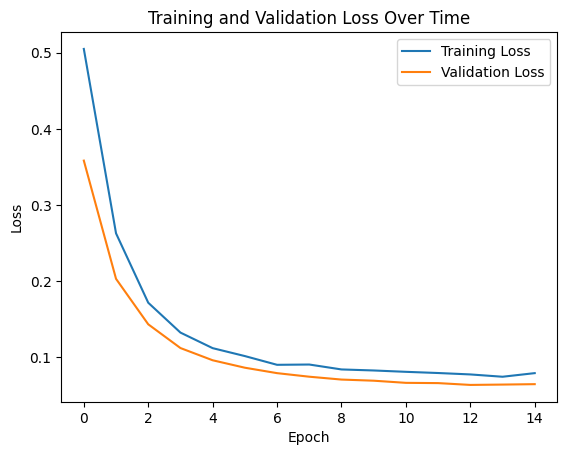

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

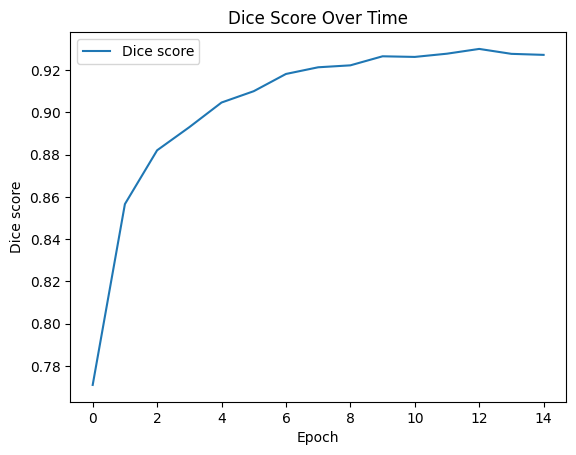

In [ ]:
plt.plot(dice_scores, label='Dice score')
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.title('Dice Score Over Time')
plt.legend()
plt.show()

# Inference debug

In [ ]:
# Inference on full images
test_image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_05.tif"
test_mask_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_05_original_mask.tif"

output_folder = "./gdrive/MyDrive/lsec_test"
# model = UNET(in_channels=1, out_channels=1, device=DEVICE, dropout_probability=config['dropout'], activation=None).to(DEVICE)
model = build_model('vgg13+imagenet', 0.0, 'dice+bce')
model.load_state_dict(torch.load(model_path))
out_mask_path = inference_on_image_with_overlap(model, test_image_path, output_folder)
merge_original_mask(test_image_path, test_mask_path, output_folder)
merge_masks(out_mask_path, test_mask_path, output_folder)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth
100%|██████████| 508M/508M [00:27<00:00, 19.3MB/s]


# **4. Inference loop**

In [ ]:
# class FunctionWrapper(nn.Module):
#   def __init__(self, model):
#     super(FunctionWrapper, self).__init__()
#     self.model = model

#     def forward(self, tensor):
#         denoised = preprocess_image(tensor)
#         return self.model(denoised)

# class SigmoidWrapper(nn.Module):
#     def __init__(self, model):
#         super(SigmoidWrapper, self).__init__()
#         self.model = model
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.model(x)
#         x = self.sigmoid(x)
#         return x

# model_path = os.path.join("./gdrive/MyDrive/lsecs", f"vgg13_dice+bce_nlm_checkpoint.pth")
# device = torch.device('cuda')
# model = build_model('vgg13+none', 0.0, 'dice+bce')
# if torch.cuda.is_available():
#     model.load_state_dict(torch.load(model_path))
# model_with_sigmoid = SigmoidWrapper(model)
# model_with_sigmoid.to(device=device)
# wrapper = FunctionWrapper(model_with_sigmoid)
# wrapper.to(device=device)
# full_model_path = os.path.join("./gdrive/MyDrive/lsecs", f"vgg13_dice+bce_nlm_sigmoid_checkpoint.pth")
# torch.save(wrapper, full_model_path)
# # wrapper = PreprocessingWrapper(denoise, model)

None
None


In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Insert Google Drive paths:**

#@markdown All Google Drive paths should start with ./gdrive/MyDrive/ (Check the folder structure in the left sidebar under **Files**).
input_images_folder = './gdrive/MyDrive/lsecs/dice_score_test/images' #@param {type:"string"}
output_mask_folder = './gdrive/MyDrive/lsecs/dice_score_test/my_masks' #@param {type:"string"}
model_path = './gdrive/MyDrive/lsecs/vgg13+imagenet_dice+bce_nlm.pth' #@param {type:"string"}

input_images_folder = input_images_folder.strip()
output_mask_folder = output_mask_folder.strip()
model_path = model_path.strip()

if not os.path.exists(output_mask_folder):
    os.makedirs(output_mask_folder)
if not os.path.exists(input_images_folder):
    print(f'{input_images_folder} does not exist)')

In [ ]:
# # model_path = os.path.join("./gdrive/MyDrive/lsecs", f"vgg13+imagenet_dice+bce_nlm.pth")
# # Inference on full images
# # images_path = "./gdrive/MyDrive/lsecs/fenestration_seg/sem_images"
# # # test_mask_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NE_05_original_mask.tif"
# # output_folder = "./gdrive/MyDrive/lsecs/fenestration_seg/new_masks"


# # images_path = "./gdrive/MyDrive/lsecs/fenestration_seg/patches/sem_images"
# masks_path = "./gdrive/MyDrive/lsecs/fenestration_seg/zapotoczny_test/edited_masks"
# masks_path = "./gdrive/MyDrive/lsecs/fenestration_seg/whole_cells/fen_mask"

# # output_folder = "./gdrive/MyDrive/lsecs/fenestration_seg/patches/new_masks"
# # if not os.path.exists(output_folder):
# #     os.makedirs(output_folder)

# image_names = [f for f in sorted(os.listdir(input_images_folder)) if os.path.isfile(os.path.join(input_images_folder, f))]
# mask_names = [f for f in sorted(os.listdir(masks_path)) if os.path.isfile(os.path.join(masks_path, f))]

# if len(image_names) != len(mask_names):
#     print(f'There are {len(image_names)} images, but {len(mask_names)} masks.')
# # print(image_names, mask_names)
# # model = build_model('vgg13+imagenet', 0.0, 'dice+bce')
# # if torch.cuda.is_available():
# #     model.load_state_dict(torch.load(model_path))
# # else:
# #     model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# model = torch.load(model_path)

In [ ]:
# for image_name, mask_name in zip(image_names, mask_names):
image_names = [f for f in sorted(os.listdir(input_images_folder)) if os.path.isfile(os.path.join(input_images_folder, f))]
model = torch.load(model_path)
for image_name in image_names:
    print(image_name)
    # print(f'{image_name} - {mask_name}')
    image_path = os.path.join(input_images_folder, image_name)
    # mask_path = os.path.join(masks_path, mask_name)
    filter = None
    output_mask = inference_on_image_with_overlap(model, image_path, filter)

    filename_ext = os.path.basename(image_path)
    filename, ext = os.path.splitext(filename_ext)
    out_mask_path = os.path.join(output_mask_folder, filename+"_new_mask"+ext)
    # Save created mask
    cv.imwrite(out_mask_path, output_mask)
    # # Merge image with created mask
    # merge = merge_images(cv.imread(image_path, cv.IMREAD_GRAYSCALE), output_mask)
    # cv.imwrite(os.path.join(output_mask_folder, filename+"_new_mask_merge"+ext), merge)


    # # print(out_mask_path)
    # # print(image_path, mask_path)
    # merge_original_mask(image_path, mask_path, output_mask_folder)
    # merge_masks(out_mask_path, mask_path, output_mask_folder)
    # # break

IV_Cal10_CB_16.tif
IV_Cal10_CB_18.tif
I_K_12.tif


# **6. Apply cell mask**

In [ ]:
mask_path = './gdrive/MyDrive/lsecs/dice_score_test/my_masks' #@param {type:"string"}
cell_mask_path = './gdrive/MyDrive/lsecs/dice_score_test/cell_masks' #@param {type:"string"}
#@markdown If this is checked, the old masks will be deleted.
rewrite_images = False # @param {type:"boolean"}

mask_path = mask_path.strip()
cell_mask_path = cell_mask_path.strip()

images = sorted([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])
cells = sorted([f for f in os.listdir(cell_mask_path) if os.path.isfile(os.path.join(cell_mask_path, f))])

if len(images) != len(cells):
    print('The number of ground truths and created masks differs.')

for image_name, cell_name in zip(images, cells):
    print(f'Image: {image_name} - cell: {cell_name}')
    im_path = os.path.join(mask_path, image_name)
    cell_path = os.path.join(cell_mask_path, cell_name)
    image = cv.imread(im_path, cv.IMREAD_GRAYSCALE)
    cell = cv.imread(cell_path, cv.IMREAD_GRAYSCALE)
    image[cell == 0] = 0
    if rewrite_images:
        new_name = image_name
        cv.imwrite(os.path.join(mask_path, new_name), image)
    else:
        new_name = image_name
        if not os.path.exists(os.path.join(mask_path, 'single_cell')):
            os.makedirs(os.path.join(mask_path, 'single_cell'))
        print(os.path.join(mask_path, 'single_cell', new_name))
        cv.imwrite(os.path.join(mask_path, 'single_cell', new_name), image)



Image: IV_Cal10_CB_16_new_mask.tif - cell: IV_Cal10_CB_16_cell.tif
./gdrive/MyDrive/lsecs/dice_score_test/my_masks/single_cell/IV_Cal10_CB_16_new_mask.tif
Image: IV_Cal10_CB_18_new_mask.tif - cell: IV_Cal10_CB_18_cell.tif
./gdrive/MyDrive/lsecs/dice_score_test/my_masks/single_cell/IV_Cal10_CB_18_new_mask.tif
Image: I_K_12_new_mask.tif - cell: I_K_12_cell.tif
./gdrive/MyDrive/lsecs/dice_score_test/my_masks/single_cell/I_K_12_new_mask.tif


# **5. Exclusion of fenestrations based on diameter and roundness**

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##**Insert the pixel size, and min and max fenestration diameters in nanometers:**

#@markdown All fenestration with a smaller or larger diameter than the chosen range will be removed from the crated masks.
#@markdown (Use dot '.' as the decimal separator, not comma ',').

#@markdown Roundness is computed as minor axis length/major axis length of a fitted ellipse.
pixel_size_nm = 10.62 #@param {type:"number"}
#@markdown ---
filter_by_diameter = False # @param {type:"boolean"}
min_diameter_nm = 105 #@param {type:"number"}
max_diameter_nm = 500 #@param {type:"number"}
#@markdown ---
filter_by_roundness = False # @param {type:"boolean"}
min_roundness = 0.2 # @param {type:"slider", min:0, max:1, step:0.1}
# #@markdown ---
# filter_by_fenestration_area = False # @param {type:"boolean"}
# min_area_nm2 = 105 #@param {type:"number"}
# max_area_nm2 = 500 #@param {type:"number"}
#@markdown ---
mask_path = './gdrive/MyDrive/lsecs/mask_edit_test' #@param {type:"string"}
#@markdown If this is checked, the old masks will be deleted.
rewrite_images = False # @param {type:"boolean"}

mask_path = mask_path.strip()
mask_names = sorted([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])

def remove_contour_from_mask(contour, mask):
    # Fill the contour with black pixels
    cv.drawContours(mask, [contour], -1, 0, thickness=cv.FILLED)
    return mask


def remove_fenestrations(mask_path, min_d, max_d, min_roundness, pixel_size_nm):
    contours = find_fenestration_contours(mask_path)
    fenestration_areas = [cv.contourArea(cnt) * (pixel_size_nm**2) for cnt in contours]
    contour_centers = find_contour_centers(contours)
    ellipses = fit_ellipses(contours, contour_centers)
    roundness_of_ellipses = []
    equivalent_diameters = []
    fenestration_areas_from_ellipses = []
    mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    # cv2_imshow(mask)
    # show_fitted_ellipses(mask_path, ellipses)

    # Remove all contours that do not fit the chosen conditions
    # Also remove all contours that were too small to fit an ellipse
    for contour, ellipse in zip(contours, ellipses):
        if ellipse is not None:
            center, axes, angle = ellipse
            # center_x, center_y = center
            minor_axis_length, major_axis_length = axes
            # print(axes)
            roundness = minor_axis_length/major_axis_length
            if roundness >= min_roundness:
                roundness_of_ellipses.append(roundness)
            # rotation_angle = angle
            diameter = pixel_size_nm * equivalent_circle_diameter(major_axis_length, minor_axis_length)
            # print(contour)
            # print(diameter)
            if filter_by_diameter and (diameter < min_d or diameter > max_d) or filter_by_roundness and (roundness < min_roundness) or np.isnan(diameter):
                mask = remove_contour_from_mask(contour, mask)
            else:
                equivalent_diameters.append(diameter)
                fenestration_areas_from_ellipses.append((diameter**2)/4*math.pi)
        else:
            mask = remove_contour_from_mask(contour, mask)
    # cv2_imshow(mask)
    # show_statistics(fenestration_areas, fenestration_areas_from_ellipses, roundness_of_ellipses, equivalent_diameters, min_roundness, min_diameter_nm, max_diameter_nm)
    equivalent_diameters = np.array(equivalent_diameters)
    # print(equivalent_diameters)
    if len(equivalent_diameters) > 0:
        mean = int(np.nanmean(equivalent_diameters) + 0.5) # This is how to round numbers in python...
        std = int(np.nanstd(equivalent_diameters) + 0.5)
        print(f"Mean equavalent diameter: {mean} nm, std: {std} nm ")
    return mask


#TODO: ukazat statistiky pro celou slozku obrazku

if not rewrite_images:
    new_mask_path = os.path.join(mask_path, 'edited_masks')
    os.makedirs(new_mask_path, exist_ok=True)
else:
    new_mask_path = mask_path
# print(new_mask_path)
for mask_name in mask_names:
    # print(mask_name)
    mask_path_full = os.path.join(mask_path, mask_name)
    # print(mask_path)
    # mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
    edited_mask = remove_fenestrations(mask_path_full, min_diameter_nm, max_diameter_nm, min_roundness, pixel_size_nm)
    # print(os.path.join(new_mask_path, mask_name))
    cv.imwrite(os.path.join(new_mask_path, mask_name), edited_mask)
    # cv.imwrite(os.path.join(new_mask_path, mask_name), mask)




## Display the number of circles and their fitted ellipses
# print("Number of fenestrations:", len(contours))
# print("Number of fitted ellipses:", len(ellipses))


Mean equavalent diameter: 171 nm, std: 45 nm 
Mean equavalent diameter: 193 nm, std: 47 nm 


# **7. Inference evaluation (dice score)**

In [10]:
# @title  { display-mode: "form" }
#@markdown Insert folders with cell images and their ground truth masks for comparison:
from sklearn.metrics import f1_score
images_path = './gdrive/MyDrive/lsecs/dice_score_test/images' #@param {type:"string"}
ground_truth_mask_folder = './gdrive/MyDrive/lsecs/dice_score_test/ground_truth_masks' #@param {type:"string"}
models_path = './gdrive/MyDrive/lsecs' #@param {type:"string"}
cell_mask_path = './gdrive/MyDrive/lsecs/dice_score_test/cell_masks' #@param {type:"string"}

log_file_path = './gdrive/MyDrive/lsecs/dice_score_test/log.txt'

ground_truth_mask_folder = ground_truth_mask_folder.strip()
images_path = images_path.strip()
models_path = models_path.strip()
cell_mask_path = cell_mask_path.strip()


model_names = sorted([f for f in os.listdir(models_path) if os.path.isfile(os.path.join(models_path, f)) and 'pt' in f])
cells = sorted([f for f in os.listdir(cell_mask_path) if os.path.isfile(os.path.join(cell_mask_path, f))])

print(model_names)



if not os.path.exists(images_path):
    print("Images folder does not exist")
    # exit()
if not os.path.exists(ground_truth_mask_folder):
    print("Folder with ground truth masks does not exist")
    # exit()

ground_truth_images = sorted([f for f in os.listdir(ground_truth_mask_folder) if os.path.isfile(os.path.join(ground_truth_mask_folder, f))])
images = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])

if len(ground_truth_images) != len(images):
    print('The number of ground truths and images differs.')
    # exit()

def compute_dice_score(image1, image2):
    eps = 1e-8
    image1[image1 == 255] = 1
    image2[image2 == 255] = 1
    intersection_sum = np.logical_and(image1, image2).sum()
    dice_score = (2*intersection_sum+eps)/(image1.sum() + image2.sum() + eps)
    return dice_score

def compute_f1(image1, image2):
    image1 = image1.flatten()
    image2 = image2.flatten()
    return f1_score(image1, image2)

with open(log_file_path, "a+") as file:
    file.write(f'{len(images)} images\n')
    for model_name in model_names:
        file.write(f'{model_name}\n')
        print(model_name)
        model = torch.load(os.path.join(models_path, model_name)) # TODO:these models do not include sigmoid and preprocessing yet
        dice_scores = []
        f1_scores = []
        if 'nlm' in model_name:
            filter_type = 'nlm'
        elif 'med5' in model_name:
            filter_type = 'med5'
        else:
            filter_type = None
        print(filter_type)
        for ground_truth_mask_name, image_name, cell_name  in zip(ground_truth_images, images, cells):
            print(f'Compare: {ground_truth_mask_name} - {image_name} - {cell_name}')
            file.write(f'Compare: {ground_truth_mask_name} - {image_name}\n')
            ground_truth_mask_path = os.path.join(ground_truth_mask_folder, ground_truth_mask_name)
            image_path = os.path.join(images_path, image_name)
            cell_path = os.path.join(cell_mask_path, cell_name)
            cell = cv.imread(cell_path, cv.IMREAD_GRAYSCALE)
            ground_truth_mask = cv.imread(ground_truth_mask_path, cv.IMREAD_GRAYSCALE)
            # image_mask = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            # output_folder = None
            new_mask = inference_on_image_with_overlap(model, image_path, filter_type)
            new_mask[cell == 0] = 0
            current_dice_score = compute_dice_score(ground_truth_mask, new_mask)
            print(f'Image Dice score: {round(current_dice_score*100, 1)}')
            file.write(f'Image Dice score: {round(current_dice_score*100, 1)}\n')
            dice_scores.append(current_dice_score)

            current_f1_score = compute_f1(ground_truth_mask, new_mask)
            print(f'Image F1 score: {round(current_f1_score*100, 1)}')
            file.write(f'Image F1 score: {round(current_f1_score*100, 1)}\n')
            f1_scores.append(current_f1_score)

        dice_scores = np.array(dice_scores)
        mean_dice = round(np.mean(dice_scores)*100, 1)
        std_dice = round(np.std(dice_scores)*100, 1)

        f1_scores = np.array(f1_scores)
        mean_f1 = round(np.mean(f1_scores)*100, 1)
        std_f1 = round(np.std(f1_scores)*100, 1)


        print(f'{model_name} Mean dice: {mean_dice} +- {std_dice}\n')
        file.write(f'{model_name} Mean dice: {mean_dice} += {std_dice}\n\n')
        print(f'{model_name} Mean F1: {mean_f1} +- {std_f1}\n')
        file.write(f'{model_name} Mean F1: {mean_f1} += {std_f1}\n\n')

# print(f'Mean dice score is {mean_dice}')



['efficientnet-b7+imagenet_dice+bce_no_denoise.pth', 'efficientnet-b7+imagenet_dice_no_denoise.pth', 'resnet18+ssl_dice+bce_no_denoise.pth', 'resnet18+ssl_dice_no_denoise.pth', 'resnet34+imagenet_dice+bce_no_denoise.pth', 'resnet34+imagenet_dice_no_denoise.pth', 'resnet50+ssl_dice+bce_no_denoise.pth', 'resnet50+ssl_dice_no_denoise.pth', 'vgg11+imagenet_dice+bce_no_denoise.pth', 'vgg11+imagenet_dice_no_denoise.pth', 'vgg11+imagenet_focal_no_denoise.pth', 'vgg13+imagenet_dice+bce_no_denoise.pth', 'vgg13+imagenet_dice_no_denoise.pth', 'vgg13+imagenet_focal_no_denoise.pth', 'vgg16+imagenet_dice+bce_no_denoise.pth', 'vgg16+imagenet_dice_no_denoise.pth', 'vgg16+imagenet_focal_no_denoise.pth', 'vgg19+imagenet_dice+bce_no_denoise.pth', 'vgg19+imagenet_dice_no_denoise.pth', 'vgg19+imagenet_focal_no_denoise.pth']
efficientnet-b7+imagenet_dice+bce_no_denoise.pth
Compare: II_Bleb20_07_mask.tif - II_Bleb20_07.tif - mask_II_Bleb20_07.tif
Image Dice score: 87.3
Compare: II_Y10_03.tif - II_Y10_03.tif 

# Bioimageio stuff

In [ ]:
# !pip install "bioimageio.core>=0.5,<0.6"

In [ ]:
# @torch.jit.ignore
# def call_np(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class MyModule(nn.Module):
#     @torch.jit.export
#     def forward(self, tensor):
#         done = call_np(tensor)
#         print (done)

# scripted_module = torch.jit.script(MyModule())
# print(scripted_module.forward.graph)
# empty_tensor = torch.empty(3, 4)
# scripted_module.forward(empty_tensor)










In [ ]:
# import torchvision.transforms as transforms
# import numpy as np

# @torch.jit.ignore
# def denoise_image(tensor) -> torch.Tensor:
#   na = tensor.numpy()
#   # Interesting stuff here
#   tt = torch.tensor(na)
#   return tt

# class FunctionWrapper(nn.Module):
#   def __init__(self, model):
#     super(FunctionWrapper, self).__init__()
#     self.model = model

#     @torch.jit.export
#     def forward(self, tensor):
#         denoised = denoise_image(tensor)
#         return self.model(denoised)



# device = torch.device('cpu')
# model = UNET(in_channels=1, out_channels=1, device='cpu')
# model.load_state_dict(torch.load(biomodel_path, map_location=device))
# # model.to(device=device)
# model = torch.jit.script(model)
# # wrapper = FunctionWrapper(model)
# wrapper.to(device=device)
# # wrapper = PreprocessingWrapper(denoise, model)
# # model = torch.jit.script(wrapper)
# #
# model.eval()
# torchscript_weights_path = os.path.join(biomodel_folder, 'torchscript_weights.pt')
# torch.jit.save(model, torchscript_weights_path)

# preprocessing=[[{"name": "scale_range",
#                  "kwargs": {"axes": "xy",
#                           #  "min_percentile": min_percentile,
#                             # "max_percentile": max_percentile,
#                             "mode": "per_sample"
#                             }}]]

# threshold = 0.5
# postprocessing = [[{"name": "binarize", "kwargs": {"threshold": threshold}}]]


In [ ]:
# input = np.random.rand(1, 1, 512, 512).astype("float32")  # an example input
# test_inputs = os.path.join(biomodel_folder, "test-input.npy")
# test_outputs = os.path.join(biomodel_folder, "test-output.npy")
# np.save(test_inputs, input)
# with torch.no_grad():
#   output = model(torch.from_numpy(input)).cpu().numpy() # copy to cpu(is on gpu because of jit.script)
#   output = output > threshold
# np.save(test_outputs, output)

# print(input.shape)
# print(output.shape)

In [ ]:
# # create markdown documentation for your model
# # this should describe how the model was trained, (and on which data)
# # and also what to take into consideration when running the model, especially how to validate the model
# # here, we just create a stub documentation
# doc_path = os.path.join(biomodel_folder, "doc.md")
# with open(doc_path, "w") as f:
#     f.write("# My First Model\n")

In [ ]:
# from bioimageio.core.build_spec import build_model
# import torch
# # now we can use the build_model function to create the zipped package.
# # it takes the path to the weights and data we have just created, as well as additional information
# # that will be used to add metadata to the rdf.yaml file in the model zip
# # we only use a subset of the available options here, please refer to the advanced examples and to the
# # function signature of build_model in order to get an overview of the full functionality
# build_model(
#     # the weight file and the type of the weights
#     weight_uri= torchscript_weights_path,
#     weight_type="torchscript",
#     # the test input and output data as well as the description of the tensors
#     # these are passed as list because we support multiple inputs / outputs per model
#     test_inputs=[test_inputs],
#     test_outputs=[test_outputs],
#     input_axes=["bcyx"],
#     output_axes=["bcyx"],
#     # where to save the model zip, how to call the model and a short description of it
#     output_path=os.path.join(biomodel_folder,"model.zip"),
#     name="MyFirstModel",
#     description="a fancy new model",
#     # additional metadata about authors, licenses, citation etc.
#     authors=[{"name": "Gizmo"}],
#     license="CC-BY-4.0",
#     documentation=doc_path,
#     tags=["nucleus-segmentation"],  # the tags are used to make models more findable on the website
#     cite=[{"text": "Gizmo et al.", "doi": "10.1002/xyzacab123"}],
#     pytorch_version=torch.__version__,
#     preprocessing=preprocessing,
#     postprocessing=postprocessing
# )

In [ ]:
# # finally, we test that the expected outptus are reproduced when running the model.
# # the 'test_model' function runs this test.
# # it will output a list of dictionaries. each dict gives the status of a different test that is being run
# # if all of them contain "status": "passed" then all tests were successful
# from bioimageio.core.resource_tests import test_model
# import bioimageio.core
# my_model = bioimageio.core.load_resource_description(os.path.join(biomodel_folder,"model.zip"))
# test_model(my_model)